# STAT778: Homework 5
*Sean Steinle*

## Table of Contents
1. [Inverse Transform Sampling and Metropolis-Hastings](#Inverse-Transform-Sampling-and-Metropolis-Hastings)
    - [Inverse Transform Sampling for G](#Inverse-Transform-Sampling-for-G)
    - [A Valid Envelope](#A-Valid-Envelope)
    - [Rejection Sampling for F](#Rejection-Sampling-for-F)
2. [Gibbs Sampling](#Gibbs-Sampling)

## Inverse Transform Sampling and Metropolis-Hastings

### Inverse Transform Sampling for G

Question 1a asks us to create a sampler for g.
1. We can treat g(x,y|z) as two independent variables g(x|z) and g(y|z).
2. Both g(x|z) and g(y|z) have the same functional form as each other. The only different is that x is distributed from (-inf,inf) while y is distributed from \[0,inf).
3. Both g(x|z) and g(y|z) have the same functional form as the Laplace distribution, where z is the location parameter and diversity is set as the square root of 2.
4. Because we know the Laplace distribution has a closed-form inverse, we can use inverse transform sampling to generate random numbers of the same functional form as g(x|z) and g(y|z).

In [70]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import uniform, normal, laplace
from numpy import sign
from math import exp, log

In [2]:
def stdtnorm(x, y):
    """Returns the density from a truncated standard normal distribution."""
    sample = normal(0, 1)
    if x < sample < y:
        return sample
    else:
        return 0
    
def gtildad(x,y):
    """Returns the density of g_tilda."""
    if y < 0: raise ValueError("y must be positive.")
    z = stdtnorm(x,y)
    return exp((-1/(2**0.5))*abs(x-z)) * exp((-1/(2**0.5))*abs(y-z))

def gtildas(x,y,n):
    """Samples n times from the bivariate distribution g_tilda."""
    #THIS ISN'T RIGHT
    return sum(gtildad(x,y) > uniform() for _ in range(n))

(array([1.5000e+01, 9.5000e+01, 9.0800e+02, 7.3210e+03, 5.5886e+04,
        3.1430e+04, 3.8210e+03, 4.7300e+02, 4.3000e+01, 8.0000e+00]),
 array([-10.25043267,  -8.13248754,  -6.01454241,  -3.89659728,
         -1.77865215,   0.33929298,   2.45723812,   4.57518325,
          6.69312838,   8.81107351,  10.92901864]),
 <BarContainer object of 10 artists>)

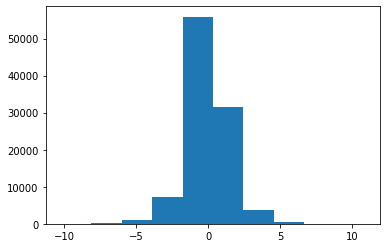

In [35]:
samples = [laplace() for _ in range(100000)]
plt.hist(samples)

In [42]:
def laplaces(mu: int = 0, beta: int = 1): #IN OUR TERMINOLOGY, mu is z!
    u = uniform()
    return mu - beta * sign(u - 0.5) * log(1 - 2 * abs(u - 0.5))

In [69]:
laplaces(0,1)

0.37976537649727

POST OFFICE HOURS TO DO LIST:
- 1a
    - treat z as a constant
    - factorize X and Y
        - they are essentially the same thing too, but y's domain is different
    - can figure out how to sample by googling how to sample laplace/double exponential
        - exponential + coin flip (+ rejection < 0 for y)
        - should check against np.random.laplace
- 1b
    - valid envelope if g's domain >= f and if g majorizes f.
    - g's domain >= f because both are from -inf>inf and 0>inf for X and Y respectively. just a trivial shift of (xtilda-ytilda) for f
    - e^|z|\*g majorizes f because ...
        - decompose max into two cases, makes things easier
- 1c
    - rejection sampling baby!
    
{\displaystyle F^{-1}(p)=\mu -b\,\operatorname {sgn}(p-0.5)\,\ln(1-2|p-0.5|).}

### A Valid Envelope

### Rejection Sampling for F

## Gibbs Sampling